# Figures etc.

Note that calling `plt.show` with high DPI makes the figures really big in Jupyterlab. This is annoying so use `plt.savefig` to get high-DPI versions of each figure.

This notebook creates each figure in a standalone function.

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import scienceplots

# science base style + sans serif fonts + grid by default
plt.style.use(["science", "notebook", "grid"])

matplotlib.rcParams["savefig.dpi"] = 300

POSTER_RC = {
    "font.size":24, 
    "axes.linewidth": 2.0, 
    "grid.linewidth": 2.0
}

PAPER_RC = {
    "font.size": 12
}

OUTPUT_FIGURE_DIRECTORY = "../figures"

### Soap Mort and West Mort extents

(<Figure size 500x300 with 2 Axes>, <GeoAxes: >, <GeoAxes: >)

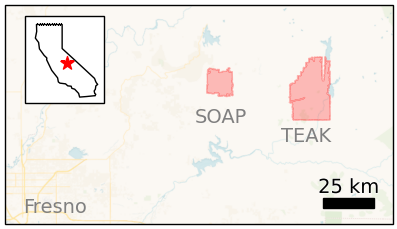

In [2]:
import yaml
import shapely
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import contextily as cx
import matplotlib_map_utils as mpl_map
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

def fig1_soap_teak_extents():
    # Get the natural earth polygon for California
    fn = shpreader.natural_earth(
        resolution='110m', category='cultural', 
        name='admin_1_states_provinces',
    )
    reader = shpreader.Reader(fn)
    cali = next(filter(lambda x: x.attributes["name"] == "California", reader.records()))
    cali = gpd.GeoSeries([cali.geometry], crs=4326)
    
    # Appproximate boundaries of SOAP and TEAK
    soap_teak = gpd.read_file("../data_in/soap_teak_extent/soap_teak_extent.gpkg").to_crs(3857)
    soap_teak = soap_teak.dissolve()
    centroid = soap_teak.centroid
    
    # Map extents
    extent_ca = -126.024414, -113.021484, 31.575612, 42.998222
    extent_fresno = -119.837744, -118.802283, 36.729433, 37.197821
    fresno = -13334904.5252,4404893.9568
    soap = -13276206.261691,4431759.156165
    teak = -13250689.547734,4425919.445224
    projection = ccrs.Mercator.GOOGLE # 3857
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 5), subplot_kw={'projection': projection})
    inset_ax = inset_axes(
        ax, width="100%", height="100%", loc='upper left',
        bbox_transform=ax.transAxes,
        axes_class=cartopy.mpl.geoaxes.GeoAxes,
        axes_kwargs=dict(projection=projection),
        bbox_to_anchor=(0, 0.6, 0.25, 0.40)
    )
    
    
    # Inset axes with California only
    cali.to_crs(projection.proj4_init).plot(ax=inset_ax, edgecolor='black', linewidth=1.0, facecolor="white")
    centroid.to_crs(projection.proj4_init).plot(ax=inset_ax, color="red", marker="*", markersize=100)
    inset_ax.set_extent(extent_ca)
    
    # Main axes with AOP boundaries
    soap_teak.plot(ax=ax, alpha=0.25, facecolor="red", edgecolor="red")
    ax.set_extent(extent_fresno)
    cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=projection, attribution=False)
    mpl_map.scale_bar(
        ax, location="lower right", 
        bar={
            "projection": projection,
            "unit": "km",
            "max": 25,
            "major_div": 1
        },
        text={"fontsize": 14},
        labels={"sep": 0, "loc": "above", "style": "last_only"},
        units={"loc": "text"}
    )
    ax.plot(*fresno, markersize=100, transform=projection._as_mpl_transform(ax))
    ax.annotate('Fresno', xy=fresno, color="0.5", fontsize=14, xycoords=projection._as_mpl_transform(ax))
    ax.annotate('SOAP', xy=soap, color="0.5", fontsize=14, xycoords=projection._as_mpl_transform(ax), horizontalalignment="center")
    ax.annotate('TEAK', xy=teak, color="0.5", fontsize=14, xycoords=projection._as_mpl_transform(ax), horizontalalignment="center")
    
    fig.set_size_inches(5, 3)

    return fig, ax, inset_ax

fig1_soap_teak_extents()

In [3]:
import xarray as xr
from matplotlib.patches import Patch

def forest_binary_raster(coarsen_factor=4):
    forest = xr.open_dataset("../mort_datasets/westmort.nc")["treecover"]
    forest = forest > 10 # FAO definition
    # Coarsen this to 4km to reduce speckle
    forest_coarse = forest.rolling(x=coarsen_factor, y=coarsen_factor).max()
    forest_coarse = forest_coarse.where(forest_coarse > 0)
    return forest_coarse

forest = forest_binary_raster(coarsen_factor=4)

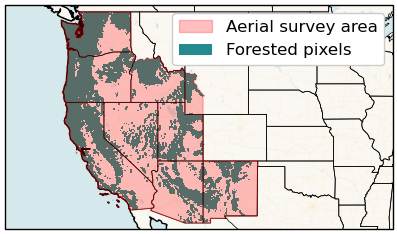

In [4]:
def fig1_west_mort_extent():
    usfs_regions = gpd.read_file("../data_in/usfs_region_boundaries/usfs_regions_simple.shp")
    usfs_regions = usfs_regions[usfs_regions.REGION.isin(["03", "04", "05", "06"])]
    usfs_dissolve = gpd.GeoSeries(usfs_regions.geometry.to_crs(3857).buffer(0.02).union_all(), crs=3857).simplify(1000)
    
    # Drop Hawaii
    generous_bbox = -14575970.6533,3602511.7427,-9808183.4092,6359699.3948
    usfs_dissolve = usfs_dissolve.clip_by_rect(*generous_bbox)
    
    # Clip forest cover to the survey boundary
    forest_clip = forest.rio.write_crs(3857).rio.clip(usfs_dissolve)
    
    projection = ccrs.Mercator.GOOGLE
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw={"projection": projection})
    
    forest_clip.plot(
        ax=ax,
        transform=projection,
        add_colorbar=False
    )
    ax.set_title("")
    
    map_bbox = (generous_bbox[0], generous_bbox[2], generous_bbox[1], generous_bbox[3]) # >:(
    
    ax.coastlines(linewidth=1.0)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    usfs_dissolve.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.25, zorder=5)
    #usfs_dissolve.plot(ax=ax, facecolor="none", edgecolor="red", alpha=1, zorder=5)
    ax.set_extent(map_bbox, crs=projection)
    cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=projection, attribution=False)
    
    patches = [
        Patch(facecolor="red", edgecolor="red", alpha=0.25, label="Aerial survey area"),
        Patch(facecolor="#238a8d", alpha=1, label="Forested pixels")
    ]
    ax.legend(handles=patches, loc="upper right", prop=dict(size=12))

    return fig, ax

fig, ax = fig1_west_mort_extent()
plt.show()

### Intersection over union vs. AC(1) heatmap

This one is kinda slow soz

In [5]:
import numpy as np
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def lag1_autocorr(arr):
    ac = acf(arr, nlags=1, missing="conservative")
    return ac[1]

def survey_mask(min_valid=0.5):
    ds = xr.open_dataset("../mort_datasets/westmort.nc")
    mort = ds.mortality.where(ds.treecover > 10)
    return (~np.isnan(mort)).astype(np.float16).mean(dim="time") > 0.5

def mort_autocor():
    ds  = xr.open_dataset("../mort_datasets/westmort.nc")
    mort = ds.mortality.where(ds.treecover > 10)
    
    return xr.apply_ufunc(
        lag1_autocorr,
        mort,
        input_core_dims=[["time"]],
        exclude_dims=set(["time"]),
        output_core_dims=[[]],
        vectorize=True
    )

def iou_mean():
    return xr.open_dataset("../mort_datasets/westmort_iou.nc").mean(dim="time")/100

mask = survey_mask()
ac = mort_autocor()
iou = iou_mean()

/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in scalar divide
  xo = x - x.sum() / notmask_int.sum()
/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:518: RuntimeWarning: invalid value encountered in divide
  acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [6]:
ac_mask = ac.where(survey_mask)
iou_mask = iou.where(survey_mask)

# Mask out the nans introduced by the survey mask
ac_flat  = ac_mask.data.flatten()
iou_flat = iou_mask.iou.data.flatten()
mask = ~(np.isnan(ac_flat) | np.isnan(iou_flat))
ac_nonan  = ac_flat[mask]
iou_nonan = iou_flat[mask]


In [7]:
(iou_nonan < 0.33).mean()

0.9993397970347455

AC(1) vs. mean IoU correlation: 0.36858198925543945


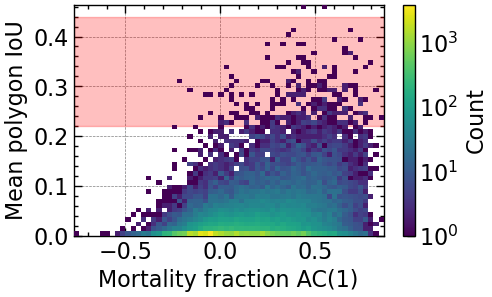

In [8]:
def fig3_autocor_heat_map():
    ac_mask = ac.where(survey_mask)
    iou_mask = iou.where(survey_mask)

    # Mask out the nans introduced by the survey mask
    ac_flat  = ac_mask.data.flatten()
    iou_flat = iou_mask.iou.data.flatten()
    mask = ~(np.isnan(ac_flat) | np.isnan(iou_flat))
    ac_nonan  = ac_flat[mask]
    iou_nonan = iou_flat[mask]
    
    fig = plt.figure(figsize=(5, 3))
    
    plt.hist2d(
        ac_nonan,
        iou_nonan,
        bins=(60, 50),
        norm=LogNorm(),
        zorder=3
    )
    
    plt.xlabel("Mortality fraction AC(1)")
    plt.ylabel("Mean polygon IoU")
    plt.colorbar(label="Count")
    plt.gca().axhspan(0.22, 0.44, alpha=0.25, color="red")

    print("AC(1) vs. mean IoU correlation:", np.corrcoef(ac_nonan, iou_nonan)[0, 1])

    return fig, plt.gca()

fig, ax = fig3_autocor_heat_map()
plt.show()

### Westmort model performance comparison

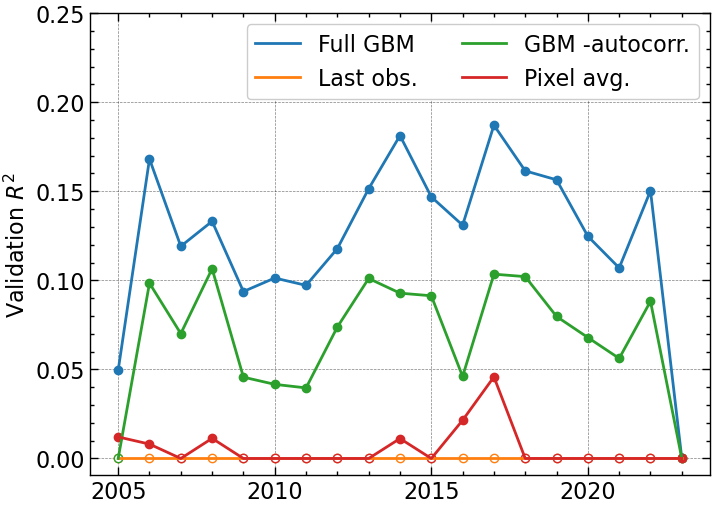

In [9]:
import pandas as pd
from matplotlib.colors import TABLEAU_COLORS

westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
westmort.head()


tableau_list = list(TABLEAU_COLORS.values())

westmort_ads = westmort[(westmort.data == "ADS")]
westmort_gfw = westmort[(westmort.data == "GFW")]

def model_performance_timeseries(df):
    model_remap = {
        "full RF": "Full GBM",
        "lastobs": "Last obs.",
        "noac RF": "GBM -autocorr.",
        "spatavg": "Pixel avg."
    }
    
    fig, ax = plt.subplots()
    
    for i, (model, data) in enumerate(df.groupby("model")):
        # Snap points < 0 to 0 for display, modify marker style to make it clear
        ev_lt0 = data["r2"] < 0
        ev_plt = np.maximum(0, data["r2"])
    
        # Start with basic line
        line = ax.plot(data["year"], ev_plt, label=model_remap[model], color=tableau_list[i])
    
        # Filled circles for years > 0
        p = ax.scatter(data["year"][~ev_lt0], ev_plt[~ev_lt0], c=tableau_list[i])
    
        # Open circles for years < 0
        ax.scatter(data["year"][ ev_lt0], ev_plt[ ev_lt0], facecolor="white", edgecolor=tableau_list[i])
    
    ax.set_xticks(range(2005, 2021, 5))
    
    plt.legend(ncol=2)
    plt.ylabel("Validation $R^2$")

    return fig, ax

def figs2_gfw_performance_timeseries():
    westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
    westmort_gfw = westmort[(westmort.data == "GFW")]
    fig, ax = model_performance_timeseries(westmort_gfw)
    ax.set_ylim(None, 0.25)
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
    return fig, ax

fig, ax = figs2_gfw_performance_timeseries()
plt.show()

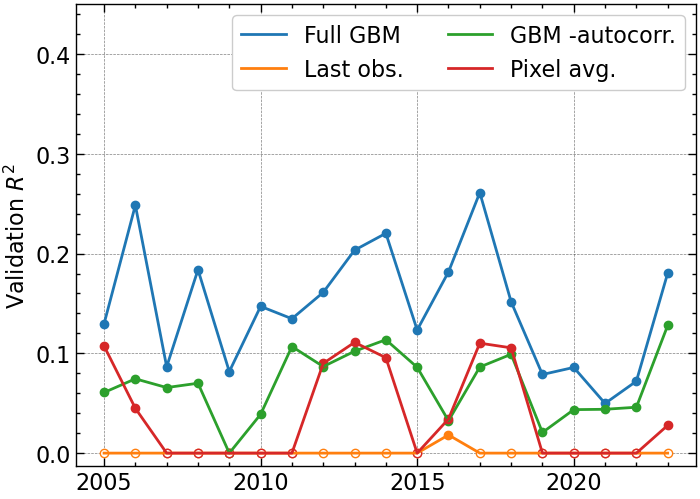

In [10]:
def figs3_ads_performance_timeseries():
    westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
    westmort_ads = westmort[(westmort.data == "ADS")]
    fig, ax = model_performance_timeseries(westmort_ads)
    ax.set_ylim(None, 0.45)
    return fig, ax

fig, ax = figs3_ads_performance_timeseries()
plt.show()

In [11]:
westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
westmort_ads = westmort[(westmort.data == "ADS")]
westmort_gfw = westmort[(westmort.data == "GFW")]

In [12]:
westmort_ads[["model", "r2"]].groupby("model").describe()

r2                                                              \
        count      mean       std       min       25%       50%       75%   
model                                                                       
full RF  19.0  0.146384  0.061524  0.049808  0.086189  0.147094  0.182729   
lastobs  19.0 -0.344830  0.187946 -0.748478 -0.427139 -0.374780 -0.219949   
noac RF  19.0  0.067007  0.038295 -0.031907  0.043753  0.070033  0.092896   
spatavg  19.0 -0.004528  0.101968 -0.242826 -0.054811 -0.015642  0.092784   

                   
              max  
model              
full RF  0.261095  
lastobs  0.018218  
noac RF  0.127946  
spatavg  0.111014

In [13]:
westmort_ads[["model", "nrmse"]].groupby("model").describe()

nrmse                                                              \
        count      mean       std       min       25%       50%       75%   
model                                                                       
full RF  19.0  0.923338  0.033482  0.859596  0.904030  0.923529  0.955935   
lastobs  19.0  1.156953  0.081475  0.990849  1.104503  1.172510  1.194629   
noac RF  19.0  0.965725  0.019702  0.933838  0.952414  0.964348  0.977879   
spatavg  19.0  1.001073  0.050136  0.942861  0.952478  1.007791  1.027030   

                   
              max  
model              
full RF  0.974778  
lastobs  1.322300  
noac RF  1.015828  
spatavg  1.114821

In [14]:
# Drop inf in the last row of each group bc missing 2023 data
westmort_gfw[["model", "r2"]]\
    .groupby("model", as_index=False)\
    .apply(lambda x: x.iloc[:-1], include_groups=True)\
    .groupby("model").describe()

/tmp/ipykernel_416/3475379952.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[:-1], include_groups=True)\


r2                                                              \
        count      mean       std       min       25%       50%       75%   
model                                                                       
full RF  18.0  0.132079  0.034844  0.049499  0.109690  0.132048  0.155187   
lastobs  18.0 -0.497421  0.230968 -1.119481 -0.579005 -0.457695 -0.366334   
noac RF  18.0  0.072319  0.029671 -0.002805  0.048575  0.076764  0.097008   
spatavg  18.0 -0.054326  0.071913 -0.190825 -0.121896 -0.046105  0.010418   

                   
              max  
model              
full RF  0.187093  
lastobs -0.187737  
noac RF  0.106521  
spatavg  0.045803

In [15]:
westmort_gfw[["model", "nrmse"]]\
    .groupby("model", as_index=False)\
    .apply(lambda x: x.iloc[:-1], include_groups=True)\
    .groupby("model").describe()

/tmp/ipykernel_416/3612404582.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[:-1], include_groups=True)\


nrmse                                                              \
        count      mean       std       min       25%       50%       75%   
model                                                                       
full RF  18.0  0.931447  0.018628  0.901614  0.919136  0.931639  0.943559   
lastobs  18.0  1.220504  0.090828  1.089833  1.168902  1.207349  1.256577   
noac RF  18.0  0.963047  0.015306  0.945240  0.950258  0.960850  0.975408   
spatavg  18.0  1.026247  0.034782  0.976830  0.994777  1.022790  1.059135   

                   
              max  
model              
full RF  0.974936  
lastobs  1.455844  
noac RF  1.001402  
spatavg  1.091249

Those time series plots are way too busy, and we don't care much about how the values evolve over time. A better approach is to compare performance across models in boxplots. We use the Friedman test for repeated measures to assess significant differences between groups.

In [16]:
from scipy.stats import friedmanchisquare, wilcoxon

def model_comparison_wilcoxon(df):
    mse_by_model = df.pivot(index="year", columns="model", values="mse")
    
    stat, p_value = friedmanchisquare(
        mse_by_model["full RF"], mse_by_model["lastobs"], mse_by_model["noac RF"], mse_by_model["spatavg"]
    )

    return stat, p_value

stat, p_value = model_comparison_wilcoxon(westmort_ads)
print(f"Value of Q: {stat:.2f}")
print(f"p value: {p_value:e}")

Value of Q: 52.64
p value: 2.185473e-11


In [17]:
stat, p_value = model_comparison_wilcoxon(westmort_gfw)
print(f"Value of Q: {stat:.2f}")
print(f"p value: {p_value:e}")

Value of Q: 54.66
p value: 8.101605e-12


Highly significant indeed. Now do multiple comparisons to see which models are different.

In [18]:
from itertools import combinations
import math

def multiple_comparison_test(df, stat="mse"):
    perf_by_model = df.pivot(index="year", columns="model", values=stat)
    
    models  = list(perf_by_model.columns)
    n_mod   = len(models)
    n_comps = math.factorial(n_mod) / 2 * math.factorial(n_mod-2)
    
    p_adj = 0.05 / n_comps
    
    for (a, b) in combinations(list(perf_by_model.columns), 2):
        res = wilcoxon(perf_by_model[a], perf_by_model[b])
        print(f"{a:<10} vs. {b:<10}: {res.statistic:.2f} ({res.pvalue:e} {res.pvalue < p_adj})")

multiple_comparison_test(westmort_ads)

full RF    vs. lastobs   : 0.00 (3.814697e-06 True)
full RF    vs. noac RF   : 0.00 (3.814697e-06 True)
full RF    vs. spatavg   : 0.00 (3.814697e-06 True)
lastobs    vs. noac RF   : 0.00 (3.814697e-06 True)
lastobs    vs. spatavg   : 1.00 (7.629395e-06 True)
noac RF    vs. spatavg   : 10.00 (1.640320e-04 True)


In [19]:
multiple_comparison_test(westmort_gfw)

full RF    vs. lastobs   : 0.00 (3.814697e-06 True)
full RF    vs. noac RF   : 11.00 (2.098083e-04 True)
full RF    vs. spatavg   : 0.00 (3.814697e-06 True)
lastobs    vs. noac RF   : 0.00 (3.814697e-06 True)
lastobs    vs. spatavg   : 0.00 (3.814697e-06 True)
noac RF    vs. spatavg   : 1.00 (7.629395e-06 True)


In [20]:
index = [0, 3, 1, 2]
print(westmort_ads.model.unique())
print(westmort_ads.model.unique()[index])

['full RF' 'noac RF' 'lastobs' 'spatavg']
['full RF' 'spatavg' 'noac RF' 'lastobs']


So only the full RF is different on ADS and all models are distinct on GFW. Show this with annotations on the boxplot.

In [21]:
def boxplot_annotate_comparison_result(df, position, annotation, annotation_x=0.8):
    '''
    Position and annotation apply to the list of models in df in alphabetical order.
    '''
    box = dict(facecolor="white", edgecolor="black")
    
    fig, ax = plt.subplots(figsize=(4.5, 8/3))

    models = df.model.sort_values().unique()
    
    df.boxplot(
        "nrmse", by="model", 
        ax=ax, vert=False, positions=position, 
        showfliers=False, 
        boxprops=dict(linewidth=2, c="tab:blue"),
        medianprops=dict(linewidth=2, c="tab:orange"),
        whiskerprops=dict(linewidth=2, c="tab:blue"),
        capprops=dict(linewidth=2, c="tab:blue")
    )
    ax.grid(False, axis="y")
    ax.tick_params(
        which="both",
        left=False,
        right=False
    )

    for anno, pos in zip(annotation, position):
        ax.annotate(anno, (annotation_x, pos), bbox=box)
    ax.set_title("")
    plt.suptitle("")
    plt.ylabel("")
    plt.xlabel("Normalized RMSE")
    return fig, ax

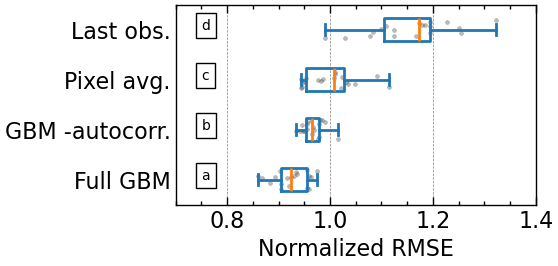

In [38]:
def fig4_ads_boxplot():
    model_to_y = {
        "full RF": '0',
        "noac RF": '1',
        "spatavg": '2',
        "lastobs": '3'
    }
    
    scatter_x = westmort_ads["nrmse"]
    scatter_y = westmort_ads["model"].replace(model_to_y).astype(int) + (0.2 * np.random.uniform(low=-1, high=1, size=westmort_ads.shape[0]))
    
    fig, ax = boxplot_annotate_comparison_result(westmort_ads, [0, 3, 1, 2], ["a", "d", "b", "c"], annotation_x=0.75)
    ax.scatter(scatter_x, scatter_y, marker='x', s=5, c='0.1', alpha=0.3)
    ax.set_xlim(0.7, 1.4)
    ax.set_yticks([0, 1, 2, 3], labels=["Full GBM", "GBM -autocorr.", "Pixel avg.", "Last obs."])
    
    return fig, ax

fig, ax = fig4_ads_boxplot()
plt.savefig(os.path.join(OUTPUT_FIGURE_DIRECTORY, "fig4_ads_boxplot.png"))
plt.show()

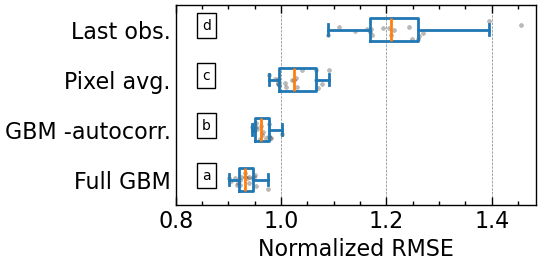

In [23]:
def figs1_gfw_boxplot():
    model_to_y = {
        "full RF": '0',
        "noac RF": '1',
        "spatavg": '2',
        "lastobs": '3'
    }
    
    scatter_x = westmort_gfw["nrmse"]
    scatter_y = westmort_gfw["model"].replace(model_to_y).astype(int) + (0.2 * np.random.uniform(low=-1, high=1, size=westmort_gfw.shape[0]))
    
    fig, ax = boxplot_annotate_comparison_result(westmort_gfw, [0, 3, 1, 2], ["a", "d", "b", "c"], annotation_x=0.85)
    ax.scatter(scatter_x, scatter_y, marker='x', s=5, c='0.1', alpha=0.3)
    ax.set_xlim(0.8, None)
    ax.set_yticks([0, 1, 2, 3], labels=["Full GBM", "GBM -autocorr.", "Pixel avg.", "Last obs."])

    return fig, ax

fig, ax = figs1_gfw_boxplot()
plt.show()

### SOAP/TEAK model performance comparison

In [24]:
soap = pd.read_csv("../data_out/soap_teak_rf_result.csv")
soap.sort_values(["data", "model"])

,Unnamed: 0,mse,nrmse,r2,exp_var,model,data
5,5,0.043814,4.094527,-15.765153,-5.515711,RF full,ADS
3,3,0.039329,3.879322,-14.049137,-4.797393,RF noac,ADS
1,1,0.061744,4.860644,-22.625864,-13.809653,last observation,ADS
0,0,0.002731,1.022311,-0.045120,0.001885,spatial average,ADS
6,6,0.051271,0.721398,0.479584,0.479780,RF full,ITM
4,4,0.084888,0.928243,0.138366,0.211594,RF noac,ITM
2,2,0.056788,0.759215,0.423592,0.504899,last observation,ITM


Eh just use a table for this.

### West mort extent with inset regions

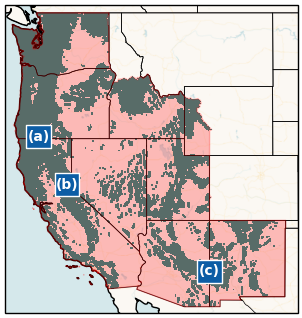

In [26]:
def get_fig5_inset_regions():
    regions = gpd.read_file("../data_in/map_inset_regions/figure_overlays.shp")
    regions["centroid_y"] = regions.geometry.centroid.y
    regions = regions.sort_values("centroid_y", ascending=False, ignore_index=True)
    regions["label"] = ["(a)", "(b)", "(c)"]

    return regions

regions = get_fig5_inset_regions()

def fig5_inset_extents():
    projection = ccrs.Mercator.GOOGLE
    tight_map_bbox = (-13947780.4623, -11360576.6138, 3620103.7979, 6343300.2344)
    #extent_ca = -126.024414, -113.021484, 31.575612, 42.998222
    
    tight_map_aspect = (tight_map_bbox[1] - tight_map_bbox[0]) / (tight_map_bbox[3] - tight_map_bbox[2])
    # ca_map_aspect = (extent_ca[1] - extent_ca[0]) / (extent_ca[3] - extent_ca[2])
    fig_height = 4
    fig_width = tight_map_aspect * fig_height
    
    # Start with the extent map, then remove legend and tighten the extent
    fig, ax = fig1_west_mort_extent()
    fig.set_size_inches(fig_width, fig_height)
    ax.get_legend().remove()
    ax.set_extent(tight_map_bbox, crs=projection)
    
    # Add summarization regions
    regions.plot(ax=ax, zorder=5, edgecolor="white")
    for x, y, label in zip(regions.centroid.x, regions.centroid.y, regions.label):
        ax.annotate(label, xy=(x, y), ha="center", va="center", color="white", weight="bold", zorder=5)

    return fig, ax

fig, ax = fig5_inset_extents()
plt.show()

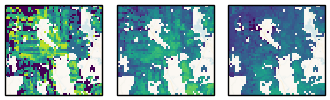

In [27]:
from matplotlib import colors
from matplotlib.cm import ScalarMappable
import pandas as pd

projection = ccrs.Mercator.GOOGLE

def get_2023_predict_result():
    ds23 = pd.read_csv("../data_out/west_ads_2023.csv")[["y", "x", "mort1", "rf_predict", "rf_predict_noac"]]\
        .set_index(["y", "x"]).to_xarray().to_array().rio.write_crs(3857)
    eps = 1e-3
    ds23 = (ds23 / 100) + eps
    return ds23

def make_clipped_plot(ds, geom, **kwargs):
    p = ds.rio.clip_box(*geom.bounds).plot(
        col="variable", 
        norm=colors.LogNorm(vmin=1e-2, vmax=1), 
        cbar_kwargs=dict(label="Proportion of cell with mortality"),
        xticks=[],
        yticks=[],
        add_labels=False,
        subplot_kws=dict(projection=projection),
        **kwargs
    )
    
    for ax in p.axs.flat:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")
        cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=projection, attribution=False)

    p.fig.tight_layout()
    return p

ds23 = get_2023_predict_result()

def fig5_row_a():
    return make_clipped_plot(ds23, regions.geometry[0], add_colorbar=False, size=4 * 0.9 / 3, cmap="viridis")

def fig5_row_b():
    return make_clipped_plot(ds23, regions.geometry[1], add_colorbar=False, size=4 * 0.9 / 3, cmap="viridis")

def fig5_row_c():
    return make_clipped_plot(ds23, regions.geometry[2], add_colorbar=False, size=4 * 0.9 / 3, cmap="viridis")


fig5_row_a()
plt.show()

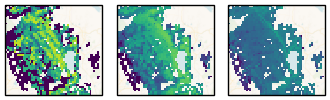

In [28]:
fig5_row_b()
plt.show()

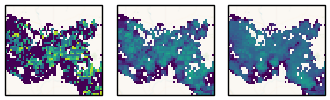

In [29]:
fig5_row_c()
plt.show()

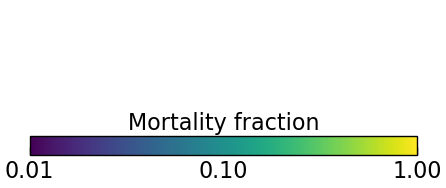

In [30]:
# Just the color bar
def fig5_colorbar():
    fig, ax = plt.subplots(figsize=(5, 2))
    
    cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=colors.LogNorm(vmin=1e-2, vmax=1), cmap='viridis'),
                 ax=ax, orientation='horizontal', label='Mortality fraction', format=matplotlib.ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))
    cb.ax.xaxis.set_label_position('top')
    ax.axis("off")
    return fig, ax

fig, ax = fig5_colorbar()
plt.show()

### Prediction, observation, & drivers by region

In [31]:
shap = xr.open_dataset("../data_out/west_ads_2023_shap.nc").__xarray_dataarray_variable__.rio.write_crs(3857)

# Sum effects by variable
weather = np.abs(shap.sel(variable=['tmin1', 'vp1', 'prcp1', 'prcp2', 'prcp3', 'prcp4', 'prcp_avg']).sum(dim="variable"))
ba      = np.abs(shap.sel(variable=['abies', 'pinus', 'populus', 'tsuga', 'pseudotsuga']).sum(dim="variable"))
topo    = np.abs(shap.sel(variable=['elev', 'slope', 'northness', 'eastness']).sum(dim="variable"))

# relativize
rel_shap = xr.concat([weather, ba, topo], dim="band") # corresponds to R, G, B
rel_shap = rel_shap / rel_shap.sum(dim="band")
rel_shap = rel_shap.transpose("y", "x", "band")

# obs/predicted values
obs = shap.sel(variable="mortality")
pred = shap.sel(variable="gbm_predict")

In [32]:
regions.geometry[0].bounds

(-13760098.782581247,
 5077447.928627404,
 -13543560.714392055,
 5278399.821997625)

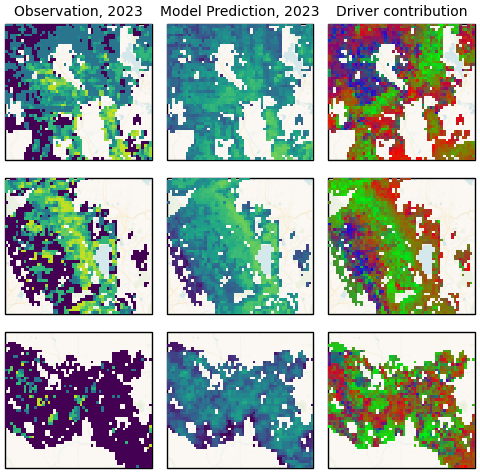

In [33]:
cmap="viridis"
norm=colors.LogNorm(vmin=1, vmax=100)
projection=ccrs.Mercator.GOOGLE

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=projection), figsize=(5, 5))

for i, geom in enumerate(regions.geometry):
    rel_shap_subset = rel_shap.rio.clip_box(*geom.bounds)
    obs_subset = obs.rio.clip_box(*geom.bounds)
    pred_subset = pred.rio.clip_box(*geom.bounds)

    # Plot predicted/observed in first two columns
    cartopy_extent = (geom.bounds[0], geom.bounds[2], geom.bounds[1], geom.bounds[3]) # >:(
    # Add 1 to shift minimum inside of color scale
    axes[i, 0].imshow(obs_subset+1, cmap=cmap, norm=norm, extent=cartopy_extent, zorder=3, interpolation="nearest", origin="lower")
    axes[i, 1].imshow(pred_subset+1, cmap=cmap, norm=norm, extent=cartopy_extent, zorder=3, interpolation="nearest", origin="lower")
    axes[i, 2].imshow(rel_shap_subset, extent=cartopy_extent, zorder=3, interpolation="nearest", origin="lower")

    for ax in axes[i, :].flat:
        cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=projection, attribution=False)


for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_title("Observation, 2023", fontsize="medium")
axes[0, 1].set_title("Model Prediction, 2023", fontsize="medium")
axes[0, 2].set_title("Driver contribution", fontsize="medium")

fig.tight_layout()
plt.show()

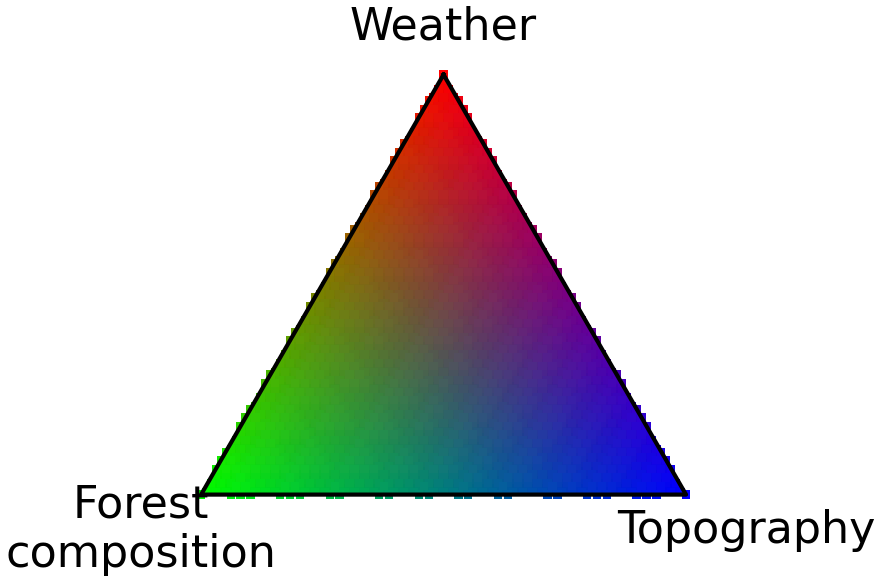

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import math

def abc_to_rgb(A=0.0,B=0.0,C=0.0):
    ''' Map values A, B, C (all in domain [0,1]) to
    suitable red, green, blue values.'''
    return (A, B, C)

# Basis vectors for triangle
basis = np.array([[0.0, 1.0], [-1.5/np.sqrt(3), -0.5],[1.5/np.sqrt(3), -0.5]])

fig = plt.figure()
ax = fig.add_subplot(111,aspect='equal')

# Plot points
a, b, c = np.mgrid[0.0:1.0:50j, 0.0:1.0:50j, 0.0:1.0:50j]
a, b, c = a.flatten(), b.flatten(), c.flatten()

abc = np.dstack((a,b,c))[0]
abc = abc[np.where(abc.sum(axis=1) < 1)]

data = np.dot(abc, basis)
colours = [abc_to_rgb(A=point[0],B=point[1],C=point[2]) for point in abc]

ax.scatter(data[:,0], data[:,1], marker=",", edgecolors='none',facecolors=colours)

# Plot triangle
ax.plot([basis[_, 0] for _ in list(range(3)) + [0]], [basis[_,1] for _ in list(range(3)) + [0]], color="black", linewidth=3)

# Plot labels at vertices

offset = 0.25
fontsize = 32
ax.text(basis[0,0]*(1+offset/2), basis[0,1]*(1+offset), 'Weather', horizontalalignment='center',
        verticalalignment='top', fontsize=fontsize)
ax.text(basis[1,0]*(1+offset), basis[1,1]*(1+offset), 'Forest\ncomposition', horizontalalignment='center',
        verticalalignment='center', fontsize=fontsize)
ax.text(basis[2,0]*(1+offset), basis[2,1]*(1+offset), 'Topography', horizontalalignment='center',
        verticalalignment='center', fontsize=fontsize)    

ax.set_frame_on(False)
ax.set_xticks(())
ax.set_yticks(())


plt.show()

### Autocorrelation statistics

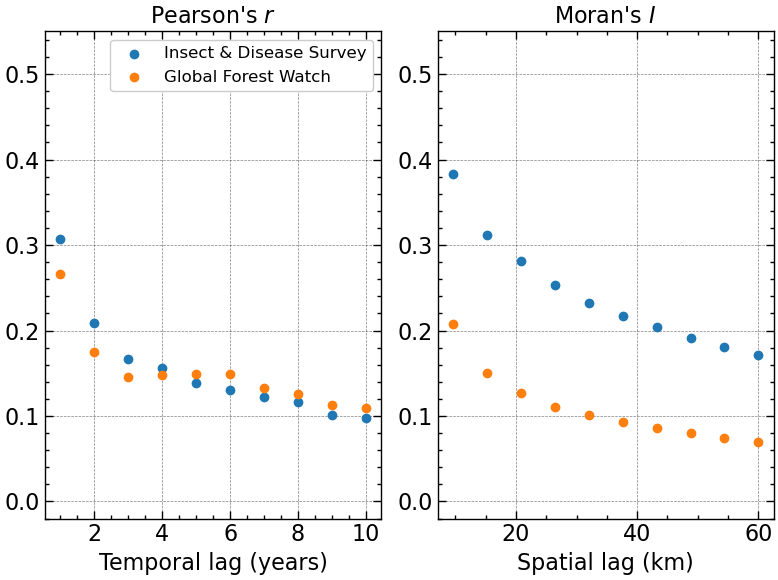

In [35]:
moran_I = pd.read_csv("../data_out/morans_I.csv")
temporal_r = pd.read_csv("../data_out/temporal_r.csv")

def fig_autocor_scatterplot():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.scatter(temporal_r["temporal_lag_yrs"], temporal_r["ads_r"], label="Insect & Disease Survey", color="tab:blue")
    ax1.scatter(temporal_r["temporal_lag_yrs"], temporal_r["gfw_r"], label="Global Forest Watch", color="tab:orange")
    ax1.set_xlabel("Temporal lag (years)")
    ax1.set_title("Pearson's $r$")
    ax1.legend(fontsize=12)
    ax1.set_ylim(-0.02, 0.55)
    
    xticks = [2, 4, 6, 8, 10]
    ax1.set_xticks(xticks, labels=map(str, xticks))
    
    ax2.scatter(moran_I["spatial_lag_km"], moran_I["ads_I"], label="Insect & Disease Survey", color="tab:blue")
    ax2.scatter(moran_I["spatial_lag_km"], moran_I["gfw_I"], label="Global Forest Watch", color="tab:orange")
    ax2.set_xlabel("Spatial lag (km)")
    ax2.set_title("Moran's $I$")
    ax2.set_ylim(-0.02, 0.55)
    
    plt.tight_layout()

    return fig, (ax1, ax2)

fig_autocor_scatterplot()
plt.show()

### Export all figures

Search the main module for all functions that start with "fig", repeatedly call them and then save the resulting figures to the output directory.

<module '__main__'>
AC(1) vs. mean IoU correlation: 0.36858198925543945


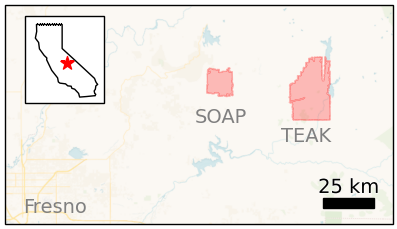

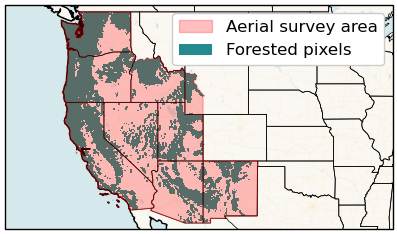

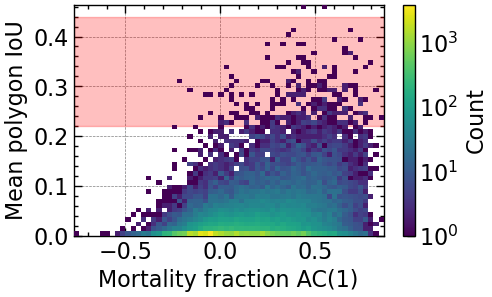

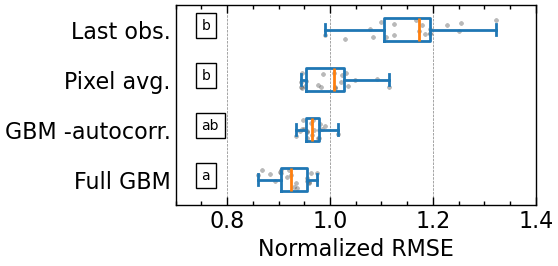

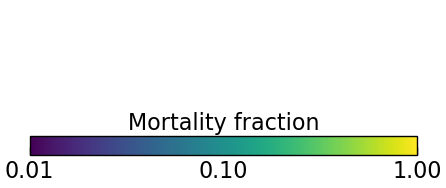

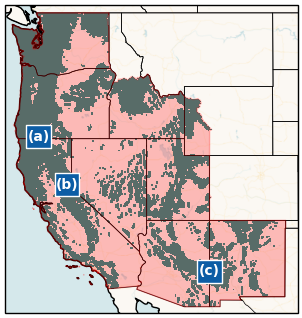

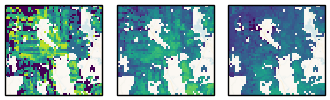

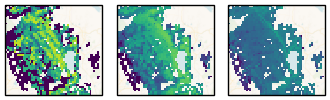

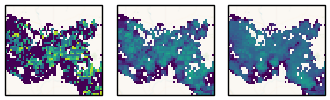

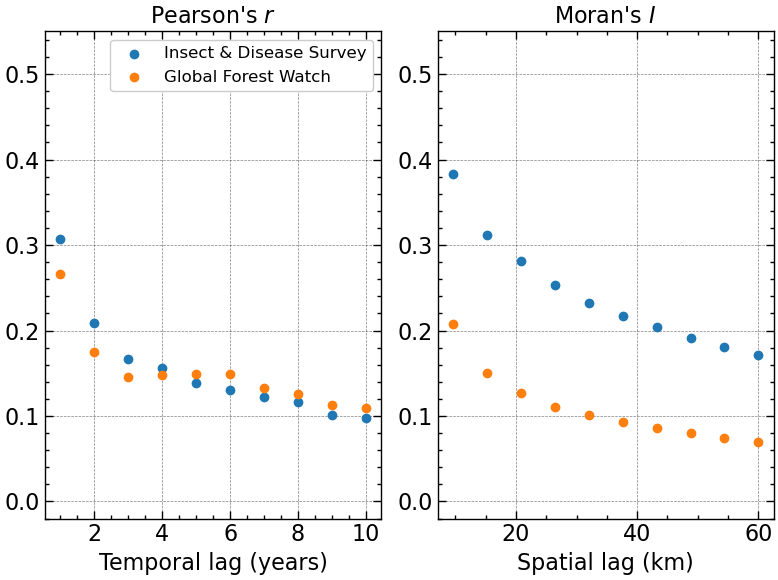

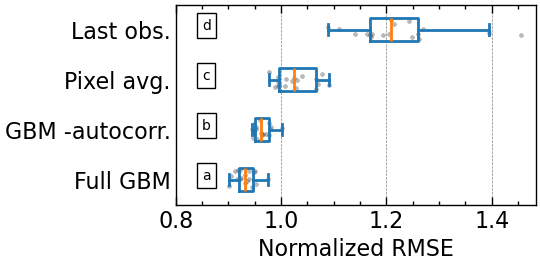

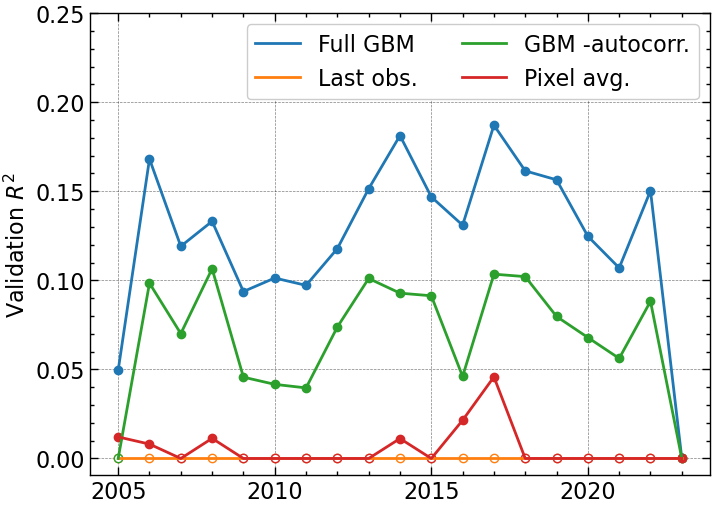

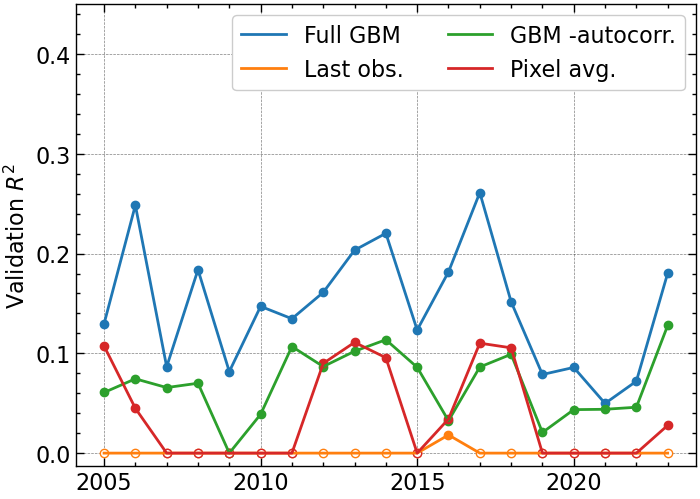

In [36]:
import sys
import os
main_module = sys.modules[__name__]
print(main_module)

fig_functions = [f for f in dir() if f.startswith("fig") and callable(getattr(main_module, f))]


for f in fig_functions:
    func = getattr(main_module, f)
    p = func()
    plt.savefig(os.path.join(OUTPUT_FIGURE_DIRECTORY, f+".png"))
